<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 NLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/NLinear.py

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [30]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [31]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/4.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.838168
1,0.814640
2,0.801280
3,0.803872
4,0.780264
...,...
38875,0.729952
38876,0.710640
38877,0.736008
38878,0.705272


In [32]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-NLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-NLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-NLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-NLinear']

In [33]:
class Model(nn.Module):
    def __init__(self,configs):
        super(Model,self).__init__()
        self.seq_len = int(configs['online-learning-NLinear']['seq_len'])
        self.pred_len = int(configs['online-learning-NLinear']['pred_len'])
        self.channels = int(configs['online-learning-NLinear']['enc_in'])
        self.individual = configs['online-learning-NLinear']['individual']
        self.device = torch.device('cuda:0')
        if self.individual == True:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len,self.pred_len)
    
    def forward(self,x):
        # x는 RNN Layer처럼 하나의 값이 하나의 텐서안에 들어가 있도록 즉 (batch_size,sequence_length,channe)
        seq_last = x[:,-1,:].view(-1,1,1) #.detach() 여기서 detach는 의미가 없어 보인다
        # https://bo-10000.tistory.com/181
        x = (x-seq_last)
        seq_last = seq_last.to(self.device)
        if self.individual == True:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype = x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])# 하나의 특성마다 각기 다른 Linear layer에 집어넣어줌
                # 이렇게 인덱싱하면 위에 처럼 linear layer에 넣기 좋게 나온다
            x = output
        else:
            x = self.Linear(x.permute(0,2,1).to(self.device)).permute(0,2,1)
            # Linear layer안에 있는 matrix와 다른 device에 들어있음
        x = x+seq_last
        return x #[Batch, Output length, Channel]

In [34]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).view(-1,1,pred_len).to(device)

In [35]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [36]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-05.


In [37]:
x_seq

tensor([[[0.8382, 0.8146, 0.8013,  ..., 0.8263, 0.8365, 0.8418]],

        [[0.8146, 0.8013, 0.8039,  ..., 0.8365, 0.8418, 0.8420]],

        [[0.8013, 0.8039, 0.7803,  ..., 0.8418, 0.8420, 0.8175]],

        ...,

        [[0.6584, 0.6867, 0.6864,  ..., 0.6986, 0.7334, 0.7053]],

        [[0.6867, 0.6864, 0.7222,  ..., 0.7334, 0.7053, 0.7150]],

        [[0.6864, 0.7222, 0.6899,  ..., 0.7053, 0.7150, 0.7057]]],
       device='cuda:0')

In [38]:
target.size()

torch.Size([27360, 1, 1])

In [39]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq.permute(0,2,1))
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')       

Adjusting learning rate of group 0 to 9.5000e-06.
smape 9.73021430164924 %
Adjusting learning rate of group 0 to 9.0250e-06.
smape 7.199799191555259 %
Adjusting learning rate of group 0 to 8.5737e-06.
smape 7.003771977401094 %
Adjusting learning rate of group 0 to 8.1451e-06.
smape 6.527694892301633 %
Adjusting learning rate of group 0 to 7.7378e-06.
smape 6.4429124455615785 %
Adjusting learning rate of group 0 to 7.3509e-06.
smape 6.440599000745872 %
Adjusting learning rate of group 0 to 6.9834e-06.
smape 6.270429553867084 %
Adjusting learning rate of group 0 to 6.6342e-06.
smape 6.177741719398931 %
Adjusting learning rate of group 0 to 6.3025e-06.
smape 6.107471211110814 %
Adjusting learning rate of group 0 to 5.9874e-06.
smape 5.9979266624854155 %
Adjusting learning rate of group 0 to 5.6880e-06.
smape 5.920100768821107 %
Adjusting learning rate of group 0 to 5.4036e-06.
smape 5.836193837846318 %
Adjusting learning rate of group 0 to 5.1334e-06.
smape 5.752952289359089 %
Adjusting l

In [40]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 12.183530360460281 %
SMAPE 6.760121785104274 %
SMAPE 5.185111951082945 %
SMAPE 0.009093866638409054 %
SMAPE 9.135428093373775 %
SMAPE 0.018567673357779313 %
SMAPE 4.830986309796572 %
SMAPE 1.1227738317102194 %
SMAPE 2.3747805301100016 %
SMAPE 1.2769237477332354 %
SMAPE 1.3738639447838068 %
SMAPE 0.0219467208822266 %
SMAPE 2.1176892146468163 %
SMAPE 0.019235429664590242 %
SMAPE 1.0126863685436547 %
SMAPE 0.12555665543413852 %
SMAPE 1.8285071803256872 %
SMAPE 0.058945162180243926 %
SMAPE 1.7216317681595685 %
SMAPE 3.218650110065937 %
SMAPE 1.6834170343354344 %
SMAPE 0.33083858284635426 %
SMAPE 10.243303939700127 %
SMAPE 0.7789923371747136 %
SMAPE 8.23983283340931 %
SMAPE 0.5375757661695388 %
SMAPE 12.457325205206871 %
SMAPE 0.08477258239838648 %
SMAPE 18.397935464978218 %
SMAPE 0.5985447958155419 %
SMAPE 16.419766068458557 %
SMAPE 1.3602682151831686 %
SMAPE 18.590894147753716 %
SMAPE 1.1569469165988266 %
SMAPE 16.07445988059044 %
SMAPE 1.3964793272316456 %
SMAPE 16.469991609454155 

SMAPE 15.672663792967798 %
SMAPE 2.320406924933195 %
SMAPE 14.327174797654152 %
SMAPE 10.291073121130466 %
SMAPE 13.61604805290699 %
SMAPE 8.914697848260403 %
SMAPE 14.090290367603304 %
SMAPE 0.6328856064519641 %
SMAPE 13.186694741249083 %
SMAPE 4.973718825727701 %
SMAPE 10.936170525848866 %
SMAPE 10.305150352418423 %
SMAPE 14.578260466456413 %
SMAPE 16.134514287114143 %
SMAPE 17.27861261367798 %
SMAPE 8.023581460118294 %
SMAPE 17.915111765265465 %
SMAPE 10.551939070224762 %
SMAPE 23.07268562912941 %
SMAPE 12.178200639784336 %
SMAPE 21.792952805757523 %
SMAPE 9.8680379986763 %
SMAPE 19.632548689842224 %
SMAPE 2.5692992452532053 %
SMAPE 19.570188745856285 %
SMAPE 3.7343194596469407 %
SMAPE 17.18160255253315 %
SMAPE 3.99415697529912 %
SMAPE 14.997013986110689 %
SMAPE 0.6084450216294499 %
SMAPE 16.809809625148773 %
SMAPE 5.162032302469015 %
SMAPE 14.70795328915119 %
SMAPE 3.974235069006681 %
SMAPE 16.72610142827034 %
SMAPE 8.19636506587267 %
SMAPE 14.385687246918677 %
SMAPE 3.265142327174

SMAPE 5.97252681478858 %
SMAPE 6.724883750081062 %
SMAPE 6.926058776676655 %
SMAPE 7.903541944921017 %
SMAPE 7.9556257873773575 %
SMAPE 7.2634368017315865 %
SMAPE 3.4142954722046848 %
SMAPE 3.017569502815604 %
SMAPE 3.0195723325014114 %
SMAPE 4.977550182491541 %
SMAPE 3.3855340033769608 %
SMAPE 4.6175095066428185 %
SMAPE 4.781492434442043 %
SMAPE 5.713478904217482 %
SMAPE 3.889667734503746 %
SMAPE 4.805897157639265 %
SMAPE 4.073858141899109 %
SMAPE 4.362844917923212 %
SMAPE 2.475002260878682 %
SMAPE 3.510918758809566 %
SMAPE 3.7952589467167854 %
SMAPE 3.0273459870368242 %
SMAPE 3.594820946455002 %
SMAPE 3.2596209589391947 %
SMAPE 3.295641534030438 %
SMAPE 5.558586288243532 %
SMAPE 2.5016102753579617 %
SMAPE 5.162955280393362 %
SMAPE 3.6078840158879757 %
SMAPE 8.814518339931965 %
SMAPE 4.718767188489437 %
SMAPE 7.017983175814152 %
SMAPE 4.163380581885576 %
SMAPE 9.032970905303955 %
SMAPE 5.099966298788786 %
SMAPE 7.638037748634815 %
SMAPE 3.680561933666468 %
SMAPE 7.424161344766617 %
SM

SMAPE 0.4721841006539762 %
SMAPE 1.325766404159367 %
SMAPE 1.5499454149976373 %
SMAPE 3.8844312466681004 %
SMAPE 1.3515950506553054 %
SMAPE 4.576515145599842 %
SMAPE 3.0552878342568874 %
SMAPE 5.008005332201719 %
SMAPE 1.306418864056468 %
SMAPE 3.9114988408982754 %
SMAPE 3.367846474051475 %
SMAPE 4.76366176456213 %
SMAPE 1.8331530317664146 %
SMAPE 4.599905151873827 %
SMAPE 2.488358372822404 %
SMAPE 6.60706327110529 %
SMAPE 3.8055380955338474 %
SMAPE 6.0981880240142345 %
SMAPE 0.5507036633789539 %
SMAPE 6.785242781043052 %
SMAPE 3.458347216248512 %
SMAPE 7.736317850649358 %
SMAPE 0.3734253436559811 %
SMAPE 5.4697083830833435 %
SMAPE 1.2375152949243784 %
SMAPE 4.284482538700104 %
SMAPE 0.3541230703704059 %
SMAPE 3.7723696753382683 %
SMAPE 0.36999289796222 %
SMAPE 4.377276435494423 %
SMAPE 1.0406998004764318 %
SMAPE 4.276255734264851 %
SMAPE 0.12124049447334072 %
SMAPE 3.6006560921669006 %
SMAPE 1.8130583930760624 %
SMAPE 4.054389279335737 %
SMAPE 3.3679102808237076 %
SMAPE 6.329848065972

SMAPE 0.31035478168632835 %
SMAPE 3.96949402242899 %
SMAPE 0.755621385294944 %
SMAPE 0.05779125095642712 %
SMAPE 3.6558707430958752 %
SMAPE 2.5509729608893394 %
SMAPE 0.13996121976606446 %
SMAPE 0.3553123385645449 %
SMAPE 1.339363170787692 %
SMAPE 0.4538951937574893 %
SMAPE 1.7407622886821628 %
SMAPE 0.5554791546892375 %
SMAPE 1.5366289783269167 %
SMAPE 0.19429390438017435 %
SMAPE 1.905348353087902 %
SMAPE 0.2764908588724211 %
SMAPE 2.52290316298604 %
SMAPE 0.16586571592961263 %
SMAPE 3.5679438672959805 %
SMAPE 0.8309667892754079 %
SMAPE 2.3343156296759844 %
SMAPE 0.2493942861619871 %
SMAPE 5.760531980544329 %
SMAPE 4.920068006962538 %
SMAPE 4.665463536977768 %
SMAPE 0.03138083927296975 %
SMAPE 7.624197565019131 %
SMAPE 0.8081187936477363 %
SMAPE 1.2314158286899328 %
SMAPE 0.6696323226206005 %
SMAPE 1.0574877373874187 %
SMAPE 0.6254803463816643 %
SMAPE 0.9292040830478071 %
SMAPE 0.7460425640456378 %
SMAPE 0.23959475813899192 %
SMAPE 0.6479968628846109 %
SMAPE 0.9971777517348528 %
SMAPE

SMAPE 5.8118955716490746 %
SMAPE 12.629575677216053 %
SMAPE 0.08540640845723146 %
SMAPE 10.650115996599197 %
SMAPE 2.261027032509446 %
SMAPE 8.313370324671268 %
SMAPE 4.208789262920618 %
SMAPE 7.90260934829712 %
SMAPE 7.276874013245107 %
SMAPE 5.717847529798746 %
SMAPE 8.597241386771202 %
SMAPE 14.402069985866547 %
SMAPE 3.3718704879283905 %
SMAPE 9.63900312781334 %
SMAPE 7.213111408054829 %
SMAPE 13.685155421495438 %
SMAPE 3.618210783228278 %
SMAPE 10.66965688765049 %
SMAPE 8.14911936223507 %
SMAPE 13.652694910764696 %
SMAPE 0.840197541518137 %
SMAPE 0.3046606567186245 %
SMAPE 2.154565083794296 %
SMAPE 4.139262568205595 %
SMAPE 1.0196325005963445 %
SMAPE 10.57790720462799 %
SMAPE 0.2602853855255489 %
SMAPE 6.898684065788984 %
SMAPE 6.401853319257497 %
SMAPE 5.048369687050581 %
SMAPE 6.312908537685871 %
SMAPE 2.090568309649825 %
SMAPE 1.4092600191943347 %
SMAPE 4.421054631471634 %
SMAPE 0.3814021953401152 %
SMAPE 1.8650908544659612 %
SMAPE 4.140664432197809 %
SMAPE 0.5635931160904875 %

SMAPE 0.08477440782780832 %
SMAPE 5.732739325612783 %
SMAPE 3.424003215506673 %
SMAPE 3.430071799084544 %
SMAPE 0.1348977396803548 %
SMAPE 6.770308330655098 %
SMAPE 5.10777947679162 %
SMAPE 12.126245625317097 %
SMAPE 5.741534173488617 %
SMAPE 5.017870057374239 %
SMAPE 8.214075945317745 %
SMAPE 6.634055882692337 %
SMAPE 8.100890137255192 %
SMAPE 4.587261039763689 %
SMAPE 5.002464286983013 %
SMAPE 5.814643990248442 %
SMAPE 0.04386803020545926 %
SMAPE 5.549427792429924 %
SMAPE 1.3635182660073042 %
SMAPE 4.638396084308624 %
SMAPE 1.0431740377098322 %
SMAPE 7.293442457914352 %
SMAPE 5.310152277350426 %
SMAPE 7.212227217853069 %
SMAPE 4.4589785151183605 %
SMAPE 9.741896770894527 %
SMAPE 2.2683563344180584 %
SMAPE 6.224774651229382 %
SMAPE 2.644788520410657 %
SMAPE 9.32832857221365 %
SMAPE 0.021947606880189596 %
SMAPE 6.305460091680288 %
SMAPE 0.32259542898691507 %
SMAPE 6.250074788928033 %
SMAPE 1.6718989219516516 %
SMAPE 9.470437049865723 %
SMAPE 1.810953114181757 %
SMAPE 7.0561282485723495

SMAPE 2.182851780205965 %
SMAPE 3.952942527830601 %
SMAPE 3.850235816091299 %
SMAPE 0.06552069222425416 %
SMAPE 1.8654031231999397 %
SMAPE 0.035779796214740145 %
SMAPE 1.5357962343841791 %
SMAPE 1.787189081311226 %
SMAPE 0.6501961122266948 %
SMAPE 0.14498355678915686 %
SMAPE 1.7359841167926788 %
SMAPE 0.17982930946163833 %
SMAPE 1.5499446261674166 %
SMAPE 0.6103255841881037 %
SMAPE 1.4506862964481115 %
SMAPE 0.23442379309562966 %
SMAPE 1.5979192033410072 %
SMAPE 0.9159397510811687 %
SMAPE 0.05135463678456632 %
SMAPE 1.3179377345368266 %
SMAPE 1.9210855867713692 %
SMAPE 1.5570703437551856 %
SMAPE 3.037316955626011 %
SMAPE 2.9545930195599794 %
SMAPE 2.574901284649968 %
SMAPE 3.2244163211435075 %
SMAPE 3.7659221924841404 %
SMAPE 2.8457217402756214 %
SMAPE 1.6517268121242525 %
SMAPE 4.523599222302437 %
SMAPE 2.6491270773112774 %
SMAPE 5.99860442429781 %
SMAPE 2.672667847946286 %
SMAPE 6.746522948145866 %
SMAPE 1.6844784123823047 %
SMAPE 5.255452334880829 %
SMAPE 1.3777110753580928 %
SMAPE 

SMAPE 1.0966977085918188 %
SMAPE 0.9858448375016451 %
SMAPE 1.4474014583975077 %
SMAPE 0.7807900253683329 %
SMAPE 0.5829589604400098 %
SMAPE 3.201189924031496 %
SMAPE 1.282336632721126 %
SMAPE 0.2215467236819677 %
SMAPE 0.014957724791202056 %
SMAPE 1.5060462905094028 %
SMAPE 0.261856657336466 %
SMAPE 0.11098581247006223 %
SMAPE 0.6980638992972672 %
SMAPE 1.6582947680726645 %
SMAPE 2.040753720328212 %
SMAPE 1.3594350470229983 %
SMAPE 0.6397568946704268 %
SMAPE 1.8803095277398825 %
SMAPE 0.921390175819397 %
SMAPE 1.018856117501855 %
SMAPE 0.7951871333643794 %
SMAPE 1.697599778883159 %
SMAPE 1.867130944505334 %
SMAPE 2.2818324007093906 %
SMAPE 1.297407105565071 %
SMAPE 0.7904637921601534 %
SMAPE 0.15578256599837914 %
SMAPE 3.8045259974896912 %
SMAPE 0.28452971659135073 %
SMAPE 0.5093916510231793 %
SMAPE 1.177339150570333 %
SMAPE 0.09882219627388622 %
SMAPE 1.4273012224584818 %
SMAPE 0.3824898451566696 %
SMAPE 0.753542116843164 %
SMAPE 1.2521604262292385 %
SMAPE 5.086149610579014 %
SMAPE 2

SMAPE 1.4957145769149065 %
SMAPE 5.793098356574774 %
SMAPE 0.5445615239441395 %
SMAPE 6.124599110335112 %
SMAPE 2.45170140825212 %
SMAPE 3.95426170900464 %
SMAPE 3.1035419702529907 %
SMAPE 5.3007703721523285 %
SMAPE 2.0200330018997192 %
SMAPE 7.5793131813406935 %
SMAPE 5.404173459857702 %
SMAPE 9.939436294138432 %
SMAPE 4.148151345551014 %
SMAPE 5.420057602226734 %
SMAPE 2.5550190452486277 %
SMAPE 2.2844288609921932 %
SMAPE 4.102620154619217 %
SMAPE 0.9205055711790919 %
SMAPE 1.0967037873342633 %
SMAPE 2.6810508277267218 %
SMAPE 0.5001755668781698 %
SMAPE 4.276280704885721 %
SMAPE 1.3609829349443316 %
SMAPE 6.123587429523468 %
SMAPE 1.8546009734272957 %
SMAPE 4.710712984204292 %
SMAPE 1.1911343531683087 %
SMAPE 0.006476632985140896 %
SMAPE 0.16884489181734352 %
SMAPE 0.008277504638044775 %
SMAPE 3.6767792366445065 %
SMAPE 1.434527867473662 %
SMAPE 0.37270949000958353 %
SMAPE 0.06767573301863195 %
SMAPE 1.6544028809294107 %
SMAPE 0.3346036215989443 %
SMAPE 0.248017243191498 %
SMAPE 2.01

SMAPE 0.5168377196342817 %
SMAPE 0.14872245854664357 %
SMAPE 8.42740298807621 %
SMAPE 9.359261222183704 %
SMAPE 6.148918233811855 %
SMAPE 7.68691386282444 %
SMAPE 11.148648336529732 %
SMAPE 1.92327790427953 %
SMAPE 4.84128937497735 %
SMAPE 6.243064232170582 %
SMAPE 0.07281461140585321 %
SMAPE 6.053093709051609 %
SMAPE 0.2633206922069178 %
SMAPE 0.400689120723257 %
SMAPE 4.707753945142031 %
SMAPE 2.0895404778420925 %
SMAPE 0.748122490280366 %
SMAPE 1.6279971888288856 %
SMAPE 2.939190125092864 %
SMAPE 0.6233619067461404 %
SMAPE 14.074858382344246 %
SMAPE 9.553874105215073 %
SMAPE 1.054751877207309 %
SMAPE 4.017726067453623 %
SMAPE 10.33747287094593 %
SMAPE 3.481740389019251 %
SMAPE 1.3937125473748893 %
SMAPE 5.037193056195974 %
SMAPE 11.7131232842803 %
SMAPE 3.7677489649504423 %
SMAPE 0.9551758942870947 %
SMAPE 0.025857914489165527 %
SMAPE 7.257926121354102 %
SMAPE 0.336269104580424 %
SMAPE 5.019140213727951 %
SMAPE 4.0742316991090775 %
SMAPE 8.523093573749065 %
SMAPE 9.374945424497128 %

SMAPE 0.15673243752826238 %
SMAPE 5.6780067421495914 %
SMAPE 0.6877679475583136 %
SMAPE 2.389561250805855 %
SMAPE 1.5550917703658342 %
SMAPE 6.011617247015238 %
SMAPE 2.0192310716956854 %
SMAPE 5.159184228628874 %
SMAPE 0.15712485784752062 %
SMAPE 2.181678043678403 %
SMAPE 4.978310067206621 %
SMAPE 1.779502084478736 %
SMAPE 0.47753312252461916 %
SMAPE 3.7964540868997574 %
SMAPE 2.1226628068834543 %
SMAPE 5.176920626312494 %
SMAPE 1.128928161226213 %
SMAPE 7.873790852725506 %
SMAPE 1.1029353085905313 %
SMAPE 3.0208681412041187 %
SMAPE 3.4447476603090763 %
SMAPE 5.721759229898453 %
SMAPE 2.0741720907390118 %
SMAPE 5.259242784231901 %
SMAPE 1.2859161933884025 %
SMAPE 4.811660382896662 %
SMAPE 3.5533835329115386 %
SMAPE 3.5208420529961586 %
SMAPE 2.417469672858715 %
SMAPE 0.20258176152128723 %
SMAPE 4.460072934627533 %
SMAPE 3.081076804548502 %
SMAPE 2.5229605436325073 %
SMAPE 1.522348233498633 %
SMAPE 1.2146545993164182 %
SMAPE 1.337723296135664 %
SMAPE 1.1795203099027276 %
SMAPE 1.903046

SMAPE 0.005934801501481957 %
SMAPE 3.999753594398499 %
SMAPE 0.20571628317702564 %
SMAPE 3.2982640154659753 %
SMAPE 0.10680973305579755 %
SMAPE 0.21144611240015368 %
SMAPE 1.802731417119503 %
SMAPE 1.9649336971342566 %
SMAPE 0.7440465893596411 %
SMAPE 2.8823038693517447 %
SMAPE 0.2789029741543345 %
SMAPE 3.6086175814270973 %
SMAPE 3.3139883689582343 %
SMAPE 3.2363169938325878 %
SMAPE 3.124622693285346 %
SMAPE 1.8753561954945326 %
SMAPE 2.3197875563055277 %
SMAPE 2.6379998214542866 %
SMAPE 3.95132365077734 %
SMAPE 0.3959620627574623 %
SMAPE 3.6497338637709618 %
SMAPE 1.6904526753351092 %
SMAPE 0.4122013140004128 %
SMAPE 4.255748510360718 %
SMAPE 0.8425431395880877 %
SMAPE 3.565766379237175 %
SMAPE 0.826534656342119 %
SMAPE 6.361844830214977 %
SMAPE 6.117841798812151 %
SMAPE 0.0023256158560158724 %
SMAPE 1.0445683104917407 %
SMAPE 1.534947800450027 %
SMAPE 1.7264798814430833 %
SMAPE 1.9235387705266476 %
SMAPE 3.9398732259869576 %
SMAPE 2.2539749536663294 %
SMAPE 10.119361132383347 %
SMAP

SMAPE 2.7633564341813326 %
SMAPE 3.186267424374819 %
SMAPE 1.6683375788852575 %
SMAPE 2.6438064724206924 %
SMAPE 4.365963544696569 %
SMAPE 3.9745621904730797 %
SMAPE 6.064496099948883 %
SMAPE 4.382147870957851 %
SMAPE 6.102837081998587 %
SMAPE 3.0999503675848246 %
SMAPE 6.953466288745404 %
SMAPE 2.7694777846336365 %
SMAPE 7.262633822858334 %
SMAPE 2.771362828090787 %
SMAPE 2.3538431525230408 %
SMAPE 2.97023051045835 %
SMAPE 0.0017849430245320266 %
SMAPE 0.9706765124574304 %
SMAPE 0.46308846632018685 %
SMAPE 1.4284991407766938 %
SMAPE 0.2841171369655058 %
SMAPE 0.3297596537740901 %
SMAPE 2.63165489025414 %
SMAPE 2.206151258200407 %
SMAPE 3.1548593137413263 %
SMAPE 3.614854451268911 %
SMAPE 3.1518638096749783 %
SMAPE 17.910657808184624 %
SMAPE 5.194841645658016 %
SMAPE 2.9991117399185896 %
SMAPE 0.42451442801393574 %
SMAPE 3.419754274189472 %
SMAPE 3.31171528249979 %
SMAPE 0.32083145540673286 %
SMAPE 3.6196171455085273 %
SMAPE 0.04530820448820805 %
SMAPE 1.1087663630023599 %
SMAPE 2.6555

SMAPE 2.6760246325284243 %
SMAPE 3.6658585779368877 %
SMAPE 1.8978765159845354 %
SMAPE 8.854159258306026 %
SMAPE 0.013595902946462958 %
SMAPE 6.398691073060035 %
SMAPE 0.6318495055893436 %
SMAPE 3.514266425743699 %
SMAPE 4.8243018463253975 %
SMAPE 10.891270861029625 %
SMAPE 0.9610419552773237 %
SMAPE 11.25537857413292 %
SMAPE 3.041285501793027 %
SMAPE 4.69399893656373 %
SMAPE 0.6539969643345103 %
SMAPE 4.770378779619932 %
SMAPE 2.5200179256498814 %
SMAPE 0.014120011295858603 %
SMAPE 0.5887554674991407 %
SMAPE 0.22543386641791585 %
SMAPE 0.16668470276204062 %
SMAPE 2.27232669852674 %
SMAPE 1.359516827389598 %
SMAPE 0.3881273983065512 %
SMAPE 0.11520548045928079 %
SMAPE 1.6918667303398254 %
SMAPE 4.100014682859182 %
SMAPE 0.008384049484902789 %
SMAPE 0.1478707698533981 %
SMAPE 4.800438340753317 %
SMAPE 0.8597314434591681 %
SMAPE 6.33206595107913 %
SMAPE 6.467049438506364 %
SMAPE 1.5100642805919051 %
SMAPE 1.282776263076812 %
SMAPE 0.0454348937313398 %
SMAPE 0.015678719376637673 %
SMAPE 4

SMAPE 2.6624469608068466 %
SMAPE 9.337865568697453 %
SMAPE 0.45936116381426473 %
SMAPE 3.0975110046565533 %
SMAPE 0.5197359750673058 %
SMAPE 0.16999390911087175 %
SMAPE 4.850257076323032 %
SMAPE 1.4926342875696719 %
SMAPE 1.893544651567936 %
SMAPE 3.9471145737916236 %
SMAPE 3.61676524952054 %
SMAPE 7.874512232840061 %
SMAPE 0.30984000159241987 %
SMAPE 7.500545896589755 %
SMAPE 2.7069486901164055 %
SMAPE 2.851774077862501 %
SMAPE 0.28706312091344444 %
SMAPE 3.3500447552651162 %
SMAPE 1.1922347724903375 %
SMAPE 1.671773168258369 %
SMAPE 1.299954638350755 %
SMAPE 0.14573466829961035 %
SMAPE 6.420255891978741 %
SMAPE 1.0945590548217297 %
SMAPE 5.033446125686169 %
SMAPE 3.9351078234612946 %
SMAPE 0.6211205422441708 %
SMAPE 4.773251641541719 %
SMAPE 1.5751885576173665 %
SMAPE 2.2693792544305325 %
SMAPE 2.083840074017644 %
SMAPE 0.7149673040257767 %
SMAPE 5.6827234998345375 %
SMAPE 6.478345308452845 %
SMAPE 5.924123898148537 %
SMAPE 2.5017818212509155 %
SMAPE 0.9002824325580149 %
SMAPE 6.1379

SMAPE 3.6628012694418426 %
SMAPE 0.8929854738526046 %
SMAPE 2.1558692418038845 %
SMAPE 0.3336511147208512 %
SMAPE 0.36975186760537326 %
SMAPE 0.7792738284915686 %
SMAPE 0.3031085883267224 %
SMAPE 1.1329287849366665 %
SMAPE 0.12773377180576517 %
SMAPE 0.01775442115248893 %
SMAPE 0.9086182839237154 %
SMAPE 0.37312101828865707 %
SMAPE 1.540003796108067 %
SMAPE 1.4072071742266417 %
SMAPE 2.944768961519003 %
SMAPE 1.9879080839455128 %
SMAPE 3.860268976539374 %
SMAPE 1.226693599484861 %
SMAPE 2.8211163375526667 %
SMAPE 0.4943973582703621 %
SMAPE 2.506675995886326 %
SMAPE 0.3495050589554012 %
SMAPE 1.7391463816165922 %
SMAPE 0.005347665268502055 %
SMAPE 2.3972741439938545 %
SMAPE 1.9914079122245312 %
SMAPE 1.1497911177575588 %
SMAPE 0.43310793745331466 %
SMAPE 0.25410596950678155 %
SMAPE 1.470588601194322 %
SMAPE 2.6818585600703955 %
SMAPE 1.1302275452762842 %
SMAPE 1.7897112090140581 %
SMAPE 1.1585069792345166 %
SMAPE 2.410815892741084 %
SMAPE 0.08177105443894561 %
SMAPE 2.175752302631736 %


SMAPE 2.239720581099391 %
SMAPE 2.066814450547099 %
SMAPE 3.9649447873234744 %
SMAPE 2.0584258157759905 %
SMAPE 3.9628905802965164 %
SMAPE 2.8021612372249365 %
SMAPE 2.01932773552835 %
SMAPE 1.6852765828371048 %
SMAPE 1.3058938095346093 %
SMAPE 0.8484749677591027 %
SMAPE 0.7919878223910928 %
SMAPE 1.4391815531998873 %
SMAPE 1.7796537410467863 %
SMAPE 0.16148950028582476 %
SMAPE 2.727685073390603 %
SMAPE 3.005130911245942 %
SMAPE 3.1323977522552013 %
SMAPE 0.89870571391657 %
SMAPE 0.9838572386652231 %
SMAPE 2.1146718077361584 %
SMAPE 2.218630701303482 %
SMAPE 2.7262388300150633 %
SMAPE 3.088189847767353 %
SMAPE 1.428648834116757 %
SMAPE 2.9702100045979023 %
SMAPE 0.03850474294409878 %
SMAPE 2.061890419572592 %
SMAPE 0.018593207480137153 %
SMAPE 2.4958033580332994 %
SMAPE 0.7235873360186815 %
SMAPE 0.2523513696505688 %
SMAPE 0.2271829624660313 %
SMAPE 1.2312203021720052 %
SMAPE 0.9718813989311457 %
SMAPE 1.46742694824934 %
SMAPE 0.20374911744147542 %
SMAPE 1.644575912505388 %
SMAPE 0.439

SMAPE 0.8488206416368484 %
SMAPE 3.292719766497612 %
SMAPE 2.3700601551681757 %
SMAPE 1.1724392790347338 %
SMAPE 1.6374720260500908 %
SMAPE 5.794321194291115 %
SMAPE 5.148059640079737 %
SMAPE 2.07600449770689 %
SMAPE 4.625962007790804 %
SMAPE 1.786511505022645 %
SMAPE 1.5897090332582593 %
SMAPE 0.8092660158872604 %
SMAPE 1.174278685823083 %
SMAPE 0.07448058092109022 %
SMAPE 0.049398838164051995 %
SMAPE 0.8540929462760687 %
SMAPE 0.0896789097372448 %
SMAPE 0.01077552511662816 %
SMAPE 0.4965008487924933 %
SMAPE 0.9374785474501551 %
SMAPE 0.05997008900993705 %
SMAPE 0.9009977309033276 %
SMAPE 1.0439483691006899 %
SMAPE 2.1252432391047478 %
SMAPE 1.7051521567627788 %
SMAPE 0.08008704071789907 %
SMAPE 0.4115287375170738 %
SMAPE 2.2327417135238647 %
SMAPE 0.038289334560033694 %
SMAPE 1.2955811927095056 %
SMAPE 1.0490472931414843 %
SMAPE 4.736873459070921 %
SMAPE 8.423068821430206 %
SMAPE 2.795032175257802 %
SMAPE 3.31417983956635 %
SMAPE 0.5991783393546939 %
SMAPE 3.533845741301775 %
SMAPE 0

SMAPE 3.2835718002170324 %
SMAPE 1.6457749241963031 %
SMAPE 0.49537090172907483 %
SMAPE 0.4578989673225351 %
SMAPE 0.8807083464926109 %
SMAPE 11.802160136401653 %
SMAPE 1.298327324911952 %
SMAPE 2.309781369753182 %
SMAPE 3.001765411347151 %
SMAPE 7.76369845867157 %
SMAPE 1.8441643817350268 %
SMAPE 9.562291972339153 %
SMAPE 1.6036922903731468 %
SMAPE 7.358206689357758 %
SMAPE 0.1550807450007028 %
SMAPE 4.389299936592579 %
SMAPE 7.06133159995079 %
SMAPE 0.18449122469428403 %
SMAPE 4.705112665891647 %
SMAPE 3.316277241334319 %
SMAPE 5.412589091807604 %
SMAPE 1.3756929249502718 %
SMAPE 0.054881857128862066 %
SMAPE 6.03973825648427 %
SMAPE 2.8635289166122675 %
SMAPE 5.302235931158066 %
SMAPE 2.762488719075918 %
SMAPE 1.7652682838961482 %
SMAPE 4.121481534093618 %
SMAPE 5.229672346264124 %
SMAPE 4.810412649065256 %
SMAPE 2.354741293936968 %
SMAPE 5.208201289176941 %
SMAPE 1.8990706773474813 %
SMAPE 3.852103630080819 %
SMAPE 4.843345645815134 %
SMAPE 5.437494121491909 %
SMAPE 0.01143796571457

SMAPE 0.016704082973888035 %
SMAPE 0.9432289684191346 %
SMAPE 1.3458534004166722 %
SMAPE 1.42145140375942 %
SMAPE 0.4198133487770974 %
SMAPE 2.135779783129692 %
SMAPE 5.557068154215813 %
SMAPE 4.672236140817404 %
SMAPE 0.20629166347407593 %
SMAPE 1.9678962379693985 %
SMAPE 3.6476651355624194 %
SMAPE 5.393016789108515 %
SMAPE 2.1571065299212933 %
SMAPE 4.470790762454271 %
SMAPE 1.005921533331275 %
SMAPE 4.234538152813911 %
SMAPE 0.06456600336903051 %
SMAPE 4.095300417393446 %
SMAPE 4.764444347470999 %
SMAPE 2.3698300886899233 %
SMAPE 2.9706551246345043 %
SMAPE 4.03957737237215 %
SMAPE 5.175806410610676 %
SMAPE 2.794083744287491 %
SMAPE 3.970542423427105 %
SMAPE 3.3343073409050703 %
SMAPE 3.0515340007841587 %
SMAPE 9.618159376084805 %
SMAPE 0.9826756902039052 %
SMAPE 6.5698062628507605 %
SMAPE 0.45302221737802023 %
SMAPE 2.7161726858466864 %
SMAPE 3.7608777992427354 %
SMAPE 5.398468296974897 %
SMAPE 2.3636650517582893 %
SMAPE 2.216141765937209 %
SMAPE 1.0534194516949356 %
SMAPE 5.0512234

SMAPE 0.048863022192449534 %
SMAPE 0.5142536119092256 %
SMAPE 0.34497155935969204 %
SMAPE 2.2658163271844387 %
SMAPE 0.002406956128197635 %
SMAPE 0.7539985836483538 %
SMAPE 1.2403751546517015 %
SMAPE 0.3182128672488034 %
SMAPE 1.123188772238791 %
SMAPE 1.2574049420654774 %
SMAPE 1.452114263549447 %
SMAPE 1.1379859996959567 %
SMAPE 1.1444963226094842 %
SMAPE 1.8304911237210035 %
SMAPE 0.012770545655257592 %
SMAPE 0.7977317036129534 %
SMAPE 0.6741180461831391 %
SMAPE 0.20717897952999917 %
SMAPE 2.9311807956546545 %
SMAPE 1.3242664150893688 %
SMAPE 4.783101033419371 %
SMAPE 2.0702536460012197 %
SMAPE 3.011965101584792 %
SMAPE 2.085015105083585 %
SMAPE 2.186235021799803 %
SMAPE 4.550382614135742 %
SMAPE 2.3557103164494038 %
SMAPE 4.015403598546982 %
SMAPE 3.4375156387686725 %
SMAPE 5.619208436459303 %
SMAPE 3.8826902993023396 %
SMAPE 6.270799744874239 %
SMAPE 0.894633297342807 %
SMAPE 6.378974314779043 %
SMAPE 2.4074593856930733 %
SMAPE 3.3454267196357255 %
SMAPE 1.209027593024075 %
SMAPE 

SMAPE 0.5860064714215696 %
SMAPE 0.950143462512642 %
SMAPE 0.002896038609250695 %
SMAPE 2.612917300313711 %
SMAPE 0.6839120308868587 %
SMAPE 4.477746371179819 %
SMAPE 0.33777538361027837 %
SMAPE 1.7233329005539417 %
SMAPE 0.7496276684105396 %
SMAPE 0.7860234822146595 %
SMAPE 0.008179806148319813 %
SMAPE 2.2345353700220585 %
SMAPE 1.7811597529798746 %
SMAPE 0.02287265638364744 %
SMAPE 1.9612858723849058 %
SMAPE 0.7036350537091494 %
SMAPE 4.1882590390741825 %
SMAPE 0.018348080121597832 %
SMAPE 3.609462793916464 %
SMAPE 0.31488872529007494 %
SMAPE 3.7147942036390305 %
SMAPE 2.2635707017034292 %
SMAPE 3.2231129556894307 %
SMAPE 2.221392696723342 %
SMAPE 1.8327406868338585 %
SMAPE 3.321139898151159 %
SMAPE 0.7479103775694966 %
SMAPE 1.5177080789580941 %
SMAPE 0.675741349812597 %
SMAPE 0.8050173074007034 %
SMAPE 0.43897959426976746 %
SMAPE 1.0981275951489806 %
SMAPE 0.0966960809930697 %
SMAPE 0.8997587226331235 %
SMAPE 0.1391251918639682 %
SMAPE 0.9593250649049877 %
SMAPE 0.8368714563548565 

SMAPE 3.36883987300098 %
SMAPE 2.6649667005985975 %
SMAPE 1.0039755823090672 %
SMAPE 4.531091827899218 %
SMAPE 4.191409178078175 %
SMAPE 2.230316396802664 %
SMAPE 0.8789863870479167 %
SMAPE 2.0101030468940735 %
SMAPE 0.14497884524303117 %
SMAPE 2.02821964584291 %
SMAPE 2.804727092385292 %
SMAPE 1.9680703356862068 %
SMAPE 7.2891903817653665 %
SMAPE 5.091953258961439 %
SMAPE 6.52481972426176 %
SMAPE 3.2700444608926773 %
SMAPE 5.603432789444923 %
SMAPE 5.025511398911476 %
SMAPE 8.58176974952221 %
SMAPE 0.02416407259987352 %
SMAPE 2.400736102834344 %
SMAPE 1.827293156646192 %
SMAPE 5.369211550801992 %
SMAPE 2.8156467601656914 %
SMAPE 7.062954664230346 %
SMAPE 5.350858852267265 %
SMAPE 3.1982379313558336 %
SMAPE 3.455670554190874 %
SMAPE 2.259638011455536 %
SMAPE 0.28073081347247353 %
SMAPE 2.009149366989732 %
SMAPE 0.6408742491621524 %
SMAPE 6.440091844648123 %
SMAPE 1.944671319797635 %
SMAPE 8.865897968411446 %
SMAPE 5.3454238548874855 %
SMAPE 3.940227176994085 %
SMAPE 6.947645470499992 %

SMAPE 1.7052151169627903 %
SMAPE 6.068452134728432 %
SMAPE 0.4273214959476377 %
SMAPE 3.638080667704344 %
SMAPE 2.975781314074993 %
SMAPE 0.6129346204252215 %
SMAPE 0.004992291616275679 %
SMAPE 9.069897472858429 %
SMAPE 1.9558189706876874 %
SMAPE 5.121854104101658 %
SMAPE 3.988151866942644 %
SMAPE 2.480283464305103 %
SMAPE 6.722916547209025 %
SMAPE 6.295720629394054 %
SMAPE 6.258440896868706 %
SMAPE 4.05428590811789 %
SMAPE 6.449799660593271 %
SMAPE 1.962944575585425 %
SMAPE 3.382850313559174 %
SMAPE 7.120545465499164 %
SMAPE 4.965118680149317 %
SMAPE 1.279665123205632 %
SMAPE 0.29657588221743936 %
SMAPE 4.644766882061958 %
SMAPE 1.1514268752071075 %
SMAPE 10.717645347118378 %
SMAPE 7.466253578662872 %
SMAPE 15.511308699846268 %
SMAPE 2.9813591111451387 %
SMAPE 11.812789782881737 %
SMAPE 10.775270193815231 %
SMAPE 11.144740208983421 %
SMAPE 16.388210341334343 %
SMAPE 4.792413864284754 %
SMAPE 13.409521542489527 %
SMAPE 11.61774019151926 %
SMAPE 5.861223712563515 %
SMAPE 13.699056610465

SMAPE 5.532760318368673 %
SMAPE 0.36862121283775195 %
SMAPE 6.221723325550556 %
SMAPE 0.4890518250176683 %
SMAPE 7.524078667163849 %
SMAPE 3.7285147942602634 %
SMAPE 6.711370706558227 %
SMAPE 3.7163649275898933 %
SMAPE 7.234571643173695 %
SMAPE 3.0650929789990187 %
SMAPE 4.868383955210447 %
SMAPE 2.175852546468377 %
SMAPE 4.138380192220211 %
SMAPE 0.9963477221317589 %
SMAPE 4.257424883544445 %
SMAPE 0.008857591305911683 %
SMAPE 7.71409697085619 %
SMAPE 1.7192892869934437 %
SMAPE 7.309566900134086 %
SMAPE 0.22273381287550362 %
SMAPE 5.240262363106012 %
SMAPE 1.4431428723037243 %
SMAPE 0.763867452275008 %
SMAPE 0.09417163651835381 %
SMAPE 0.441513926605694 %
SMAPE 0.009001861498575181 %
SMAPE 2.598637230694294 %
SMAPE 0.6781823509372771 %
SMAPE 1.7968517905101182 %
SMAPE 1.3797285286709666 %
SMAPE 2.362620221450925 %
SMAPE 3.3739444725215435 %
SMAPE 1.1531216138973832 %
SMAPE 2.0728875156491995 %
SMAPE 0.4260770099936053 %
SMAPE 2.2696157079190016 %
SMAPE 1.302895199507475 %
SMAPE 1.3886

SMAPE 2.139268981292844 %
SMAPE 0.009707859608056424 %
SMAPE 2.8699636068195105 %
SMAPE 1.0152479661628604 %
SMAPE 2.5844731125980616 %
SMAPE 2.0869207344949245 %
SMAPE 3.026746328920126 %
SMAPE 0.6053385962732136 %
SMAPE 2.726244855672121 %
SMAPE 0.35911628999747336 %
SMAPE 2.207234373316169 %
SMAPE 0.09272346209081661 %
SMAPE 1.6106670005246997 %
SMAPE 0.24525915284175423 %
SMAPE 0.3595309783704579 %
SMAPE 0.98161437548697 %
SMAPE 1.3674826826900244 %
SMAPE 1.2834306079894304 %
SMAPE 2.505464620888233 %
SMAPE 2.5683981627225876 %
SMAPE 1.3361864788457751 %
SMAPE 1.7281841859221456 %
SMAPE 2.587399810552597 %
SMAPE 3.098106622695923 %
SMAPE 3.0198364853858948 %
SMAPE 2.251475613564253 %
SMAPE 1.9847740493714807 %
SMAPE 2.0270955618470907 %
SMAPE 4.609220866113901 %
SMAPE 3.0991188902407885 %
SMAPE 3.5848234109580517 %
SMAPE 0.8191995676606895 %
SMAPE 1.4024340165778995 %
SMAPE 0.5558524383231997 %
SMAPE 2.4943919014185667 %
SMAPE 0.22441804117988795 %
SMAPE 0.8940102062188088 %
SMAPE 

SMAPE 2.294326404109597 %
SMAPE 0.3973310384899378 %
SMAPE 1.6974834902212026 %
SMAPE 1.8875634502619505 %
SMAPE 2.258826345205307 %
SMAPE 2.350830776616931 %
SMAPE 0.739759526681155 %
SMAPE 0.018352103082690974 %
SMAPE 2.8862995356321335 %
SMAPE 0.2919294881867245 %
SMAPE 4.742744706571102 %
SMAPE 1.797443414106965 %
SMAPE 5.868349391967058 %
SMAPE 1.5693913828581572 %
SMAPE 0.48802068759687245 %
SMAPE 5.9660131596028805 %
SMAPE 3.320818889886141 %
SMAPE 0.9057497219182552 %
SMAPE 1.3956795167177916 %
SMAPE 1.2890661442652345 %
SMAPE 1.5702539440244436 %
SMAPE 0.021808655101452246 %
SMAPE 1.4998781820759177 %
SMAPE 1.1035891864448786 %
SMAPE 4.335563063621521 %
SMAPE 3.4483380243182182 %
SMAPE 3.821000464260578 %
SMAPE 3.929279465228319 %
SMAPE 3.597002722322941 %
SMAPE 2.032712386921048 %
SMAPE 2.999765796586871 %
SMAPE 1.8958448674529793 %
SMAPE 0.1841932427487336 %
SMAPE 0.7261753235943615 %
SMAPE 1.663092347793281 %
SMAPE 2.121650844812393 %
SMAPE 1.3884433964267373 %
SMAPE 0.0306

SMAPE 5.3777933567762375 %
SMAPE 0.4753213162184693 %
SMAPE 5.770117301493883 %
SMAPE 1.2184118293225765 %
SMAPE 8.00985062867403 %
SMAPE 5.09435286000371 %
SMAPE 7.769214510917663 %
SMAPE 4.400062311440706 %
SMAPE 1.5569704174995422 %
SMAPE 5.159375485032797 %
SMAPE 5.171843770891428 %
SMAPE 0.17669821404945196 %
SMAPE 4.505023751407862 %
SMAPE 2.568765290081501 %
SMAPE 4.8975481279194355 %
SMAPE 2.1381964087486267 %
SMAPE 9.058120891451836 %
SMAPE 0.670598094118759 %
SMAPE 5.629941213876009 %
SMAPE 2.4372918903827667 %
SMAPE 3.699129585176706 %
SMAPE 4.387433961033821 %
SMAPE 7.277856945991516 %
SMAPE 7.80532156676054 %
SMAPE 3.9591415338218217 %
SMAPE 7.47050604224205 %
SMAPE 4.023585077375174 %
SMAPE 4.696774609386921 %
SMAPE 0.9763876907527447 %
SMAPE 0.5227858737343922 %
SMAPE 2.143549431115389 %
SMAPE 0.9818770326673985 %
SMAPE 2.2185784336179495 %
SMAPE 0.31997354409213585 %
SMAPE 4.897993259131908 %
SMAPE 0.01647191254818381 %
SMAPE 6.386839911341667 %
SMAPE 0.0086325544310170

SMAPE 5.49970331415534 %
SMAPE 8.375902257859707 %
SMAPE 0.013312464740351969 %
SMAPE 9.730123206973076 %
SMAPE 3.2175027150660758 %
SMAPE 7.980708658695221 %
SMAPE 1.3239206518046558 %
SMAPE 3.9999471083283424 %
SMAPE 0.008837121663276548 %
SMAPE 0.4544145530599053 %
SMAPE 0.08646260562579755 %
SMAPE 0.03801623458855374 %
SMAPE 0.7176944711227407 %
SMAPE 2.5705003701150417 %
SMAPE 0.035076370879323804 %
SMAPE 0.3801838262129422 %
SMAPE 1.0302200657315552 %
SMAPE 7.464960150420666 %
SMAPE 2.2790022818371654 %
SMAPE 0.10840258550354066 %
SMAPE 2.495795540511608 %
SMAPE 3.2012675516307354 %
SMAPE 1.3006851230747998 %
SMAPE 5.639428928494453 %
SMAPE 0.11080404075028127 %
SMAPE 5.563729714602232 %
SMAPE 0.33059727802265115 %
SMAPE 0.3365492757584434 %
SMAPE 3.983238879591226 %
SMAPE 0.05984019452148459 %
SMAPE 5.575631134212017 %
SMAPE 2.3567294739186764 %
SMAPE 2.854933286085725 %
SMAPE 2.11623820848763 %
SMAPE 1.2405754891224205 %
SMAPE 0.7340029267361388 %
SMAPE 0.4097265991495078 %
SMA

SMAPE 1.6335261063650253 %
SMAPE 8.14110166579485 %
SMAPE 0.009770406801202114 %
SMAPE 1.9970690272748468 %
SMAPE 5.54514243081212 %
SMAPE 1.8749464023858309 %
SMAPE 3.8647705279290676 %
SMAPE 2.332185283303261 %
SMAPE 3.8637778721749783 %
SMAPE 5.376043513417244 %
SMAPE 0.490388656500727 %
SMAPE 5.222407955676317 %
SMAPE 5.504330798983574 %
SMAPE 9.419960930943489 %
SMAPE 1.9512527529150245 %
SMAPE 1.9540804084390402 %
SMAPE 0.07677167684187225 %
SMAPE 0.9234675131738186 %
SMAPE 1.18584840092808 %
SMAPE 0.7012578016147017 %
SMAPE 0.4424738322850317 %
SMAPE 1.0595843689516187 %
SMAPE 2.2281097881495953 %
SMAPE 8.754789620637894 %
SMAPE 0.11888696628147954 %
SMAPE 5.50240758061409 %
SMAPE 0.034749950305354105 %
SMAPE 4.927575591951609 %
SMAPE 2.803753823041916 %
SMAPE 5.238911647349596 %
SMAPE 4.211882077157497 %
SMAPE 4.059871759265661 %
SMAPE 9.062985762953758 %
SMAPE 0.8271329686976969 %
SMAPE 5.448049250990152 %
SMAPE 4.876474544405937 %
SMAPE 1.6015635272487998 %
SMAPE 0.0479702989

SMAPE 2.3661779537796974 %
SMAPE 1.620619776658714 %
SMAPE 0.25006625830428675 %
SMAPE 1.1844139732420444 %
SMAPE 1.3399873562157154 %
SMAPE 1.1890093283727765 %
SMAPE 1.3847493771463633 %
SMAPE 1.0179746570065618 %
SMAPE 2.3516146931797266 %
SMAPE 1.4502912256866693 %
SMAPE 4.467808902263641 %
SMAPE 0.6862823059782386 %
SMAPE 0.52788829151541 %
SMAPE 1.167290385812521 %
SMAPE 1.3718327702954412 %
SMAPE 0.4866697450634092 %
SMAPE 2.0678955912590027 %
SMAPE 2.7271674629300833 %
SMAPE 1.1708494098857045 %
SMAPE 0.13193687621378558 %
SMAPE 0.21820518164895475 %
SMAPE 0.03037692741384035 %
SMAPE 2.0005127023905516 %
SMAPE 1.0771413715556264 %
SMAPE 1.9894886240363123 %
SMAPE 6.746767766773701 %
SMAPE 6.766790501773358 %
SMAPE 6.244214002043009 %
SMAPE 6.432101398706436 %
SMAPE 5.608611833304167 %
SMAPE 8.49372187256813 %
SMAPE 5.54518673568964 %
SMAPE 6.106166310608387 %
SMAPE 0.7204539491795003 %
SMAPE 6.593620218336582 %
SMAPE 2.152001917362213 %
SMAPE 5.211161680519581 %
SMAPE 2.5604990

SMAPE 0.9583894452080131 %
SMAPE 8.634544037282467 %
SMAPE 1.4568777298554778 %
SMAPE 8.562948539853096 %
SMAPE 0.2583843446918763 %
SMAPE 3.3610480539500713 %
SMAPE 0.8627772149629891 %
SMAPE 2.614458564668894 %
SMAPE 2.2047807089984417 %
SMAPE 3.765740517526865 %
SMAPE 3.0099996235221624 %
SMAPE 5.1041474267840385 %
SMAPE 2.4191592670977116 %
SMAPE 5.597875747829676 %
SMAPE 1.8778798952698708 %
SMAPE 5.037502363324165 %
SMAPE 1.4597615133970976 %
SMAPE 4.50834646821022 %
SMAPE 2.376350125297904 %
SMAPE 4.9795483984053135 %
SMAPE 0.6596674537286162 %
SMAPE 3.899418406188488 %
SMAPE 4.158358488231897 %
SMAPE 5.661684654653072 %
SMAPE 1.8923373259603977 %
SMAPE 7.212227888405323 %
SMAPE 3.1322633381932974 %
SMAPE 1.9072881154716015 %
SMAPE 3.1604528184980154 %
SMAPE 0.10477163320592808 %
SMAPE 1.9819884542375803 %
SMAPE 1.0783709064126015 %
SMAPE 2.130021646618843 %
SMAPE 1.603117770515382 %
SMAPE 0.0339087724678393 %
SMAPE 1.419802420772612 %
SMAPE 0.18630283230595523 %
SMAPE 0.0869473

In [41]:
target=list(target.values.reshape(-1))

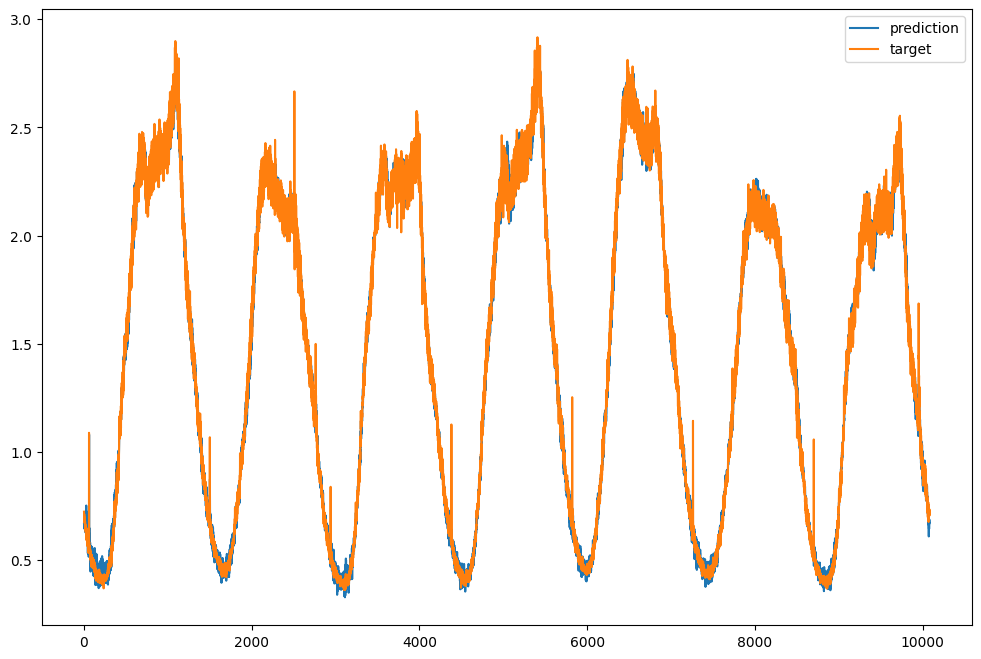

In [42]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [43]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 3.4696149826049805 %


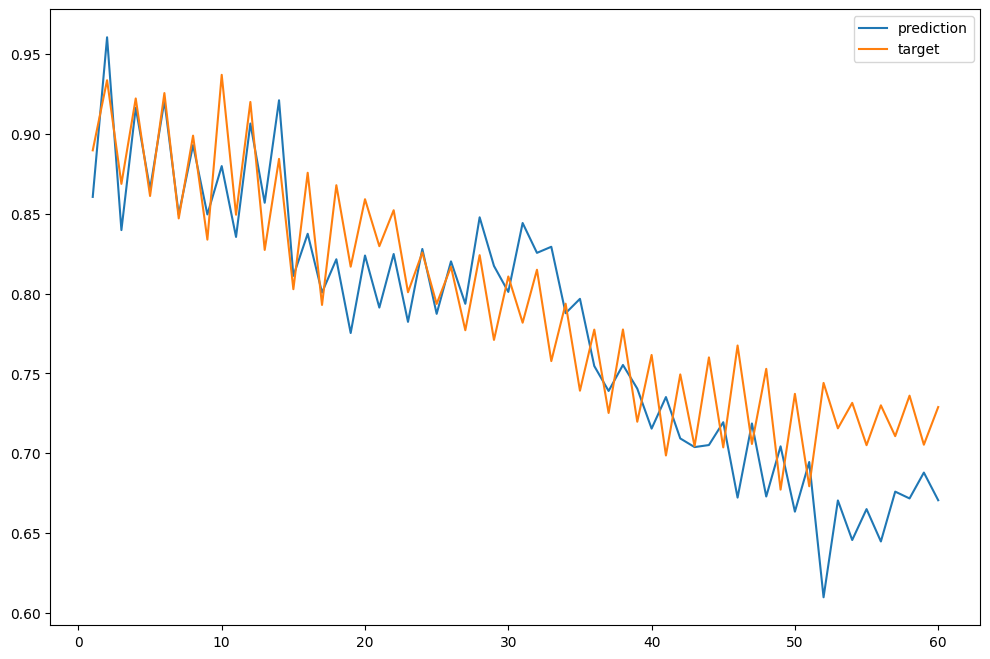

In [44]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [45]:
np.mean(time_list)

0.37671997346102243